<a href="https://colab.research.google.com/github/KabyZon/pattern-recognition/blob/master/PolynomialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***1. GENERACIÓN DE DATOS***
###Implementamos una función para la generación de 200 sets de datos $D = \{(x_i,t_i)\}_{(i=1,...,10)}$   . Los $x_i$ serán aleatorios y estarán distribuídos uniformemente dentro del intervalo $[0, 1]$. Para cada $x_i$ se generará independientemente un valor $t_i$ = $sin(2πx_i) + r$ correspondiente, donde $r$ será ruido Gaussiano $N (0, 0.3^2)$.







In [1]:
#GENERACION DE DATOS  
import numpy as np
import math
class generar_datos():
    def __init__(self,a,b,mu,sigma,N,L):
        self.a = a
        self.b = b
        self.mu = mu
        self.sigma = sigma
        self.N = N
        self.L = L
    def crearTargets(self,x):
        ruido = np.random.normal(self.mu, self.sigma**2)
        return math.sin(2*(np.pi)*x) + ruido

    def generar_set(self):
        X = np.random.uniform(self.a, self.b, self.N)
        X.sort()
        return [X, np.array([self.crearTargets(x) for x in X])]
    
    def generar_D(self) :
        D = []
        for i in range(0, L):
            D.append(self.generar_set())
        return D

In [6]:
#PLOTEAR 
import math
import matplotlib.pyplot as plt

eje_x = np.linspace(0, 1, 100)
senoidal = np.sin(2*math.pi*eje_x)
def plotear(d):
    plt.plot(eje_x, senoidal,'c-',label= "sin(2πx)")
    plt.legend(loc="upper right")
    plt.plot(d[0], d[1],'m o',label ="Datos")
    plt.legend(loc="upper right")
    
    #plt.grid(True, which='both')
    #plt.axhline(y=0, color='k')
    



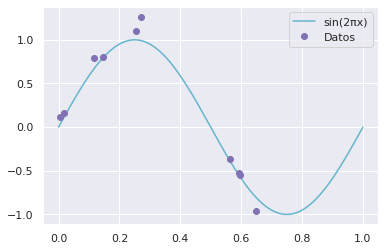

In [19]:
a = 0
b = 1
sigma = 0.3
mu = 0
N = 10
L = 200
generador = generar_datos(a,b,mu,sigma,N,L)
D = generador.generar_D()
plotear(D[0])

# **2. ENTRENAMIENTO DE DATOS** 
###Implementamos una función que devuelva el vector de pesos óptimo $w^∗$ para un set de datos $D$, un grado de polinomio $M$ y error cuadrático sin término de regularización $ED(w)$ y con término de regularización $E(w)$.

###Estimamos el valor medio del error y su desviación standard en ambos casos utilizando los 200 sets de datos generados en el primer punto.

\begin{array}{{|c|c|c|}}
\text{Orden}&\text{Regularizador}&\text{Error Medio}&\text{Desvío Standard}&\text{Máximo EM}&\text{MínimoEM}\\
\hline
8&0&3.719&21.43&119.43&2.198e-07\\
\hline
8&0.5& 2.105&0.618& 3.762&0.786\\
\hline
8&e^{-18}&0.016&0.0108&0.059&0.0003\\
\hline
3&0&0.0301&0.0189&0.112&0.002\\
\hline
3&0.5&1.225&0.280&2.184&0.305\\
\hline
3&e^{-18}&0.0311&0.0167& 0.112&0.0024\\
\end{array}



In [3]:
#CONSEGUIR Ws
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
                    
class modelo:
        
    def __init__(self,d,reg,orden):
        self.x = d[0]
        self.y = d[1].reshape(len(d[1]),1)
        self.reg = reg
        self.orden = orden
        self.mat = PolynomialFeatures(orden).fit_transform(d[0][:, None])
    
    def w(self):
      try:
        regu = self.reg * np.identity(self.orden+1)
        i = np.linalg.inv(regu + np.matmul(np.transpose(self.mat),self.mat) )
        j = np.matmul(i,np.transpose(self.mat))
        return np.matmul(j,self.y)
     
      except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):     #CASO LAMBDA =0,PUEDE SER SINGULAR
          ip = np.linalg.pinv(self.mat )
          return np.matmul(ip,self.y)
            
        else:
          raise


In [4]:
def error_cuadratico(ypred,y):
    ret = ((ypred - y)**2).sum()
    return ret/2

def errorRegularizador(ypred,y,w,reg):
    ws = (w**2).sum()
    res = error_cuadratico(ypred,y) + (reg*ws)/2
    return res 

def desvio(e,eMedio) :
    res = 0
    for i in range (0,len(e)):
        res += (e[i] - eMedio)**2
    res = res/ len(e) 
    res = res**0.5
    return res   

In [5]:
def prediccion(w,x,orden):
    pol = PolynomialFeatures(orden)
    i = np.array([x])
    s = pol.fit_transform(i[:, None])
    return np.matmul(s,w)[0][0]
def pred (W,X,orden):
    return[prediccion(W,x,orden) for x in X]

#ENTRENA SOBRE TODOS LOS SETS DE DATOS Y DEVUELVE CADA W y SUS RESPECTIVOS ERRORES
def train(D,orden,reg,hasta):
    errores=[]
    ws = []
    for i in range (0,hasta):
        mod= modelo(D[i],reg,orden)
        w = mod.w()
        ws.append(w)
        yfit = pred(w,D[i][0],orden)
        e= errorRegularizador(yfit,D[i][1],w,reg)
        errores.append(e)
    return [errores,ws]

In [7]:
#ENTRENAMIENTO PARA (ORDEN,REG)
orden= 3
reg = math.exp(-18)

entrenamiento = train(D,orden,0,len(D))  
       # sin regularizador
entrenamiento3 = train(D,orden,math.exp(-10),len(D))  
entrenamientoR = train(D,orden,reg,len(D))     # con regularizador

errores_sets = entrenamiento[0]
errorMedio = sum(errores_sets)/len(errores_sets)
desvioError = desvio(errores_sets,errorMedio)

errores_setsR = entrenamientoR[0]
errorMedioR = sum(errores_setsR)/len(errores_setsR)
desvioErrorR = desvio(errores_setsR,errorMedioR)

print("Sin Regularizador:")
print("error medio = ",errorMedio, "; desvio = " ,desvioError)
print("Con Regularizador:")
print("error medio = ",errorMedioR, "; desvio = " ,desvioErrorR)

Sin Regularizador:
error medio =  0.032798262763571645 ; desvio =  0.018607708934694364
Con Regularizador:
error medio =  0.032815201693433126 ; desvio =  0.01860728712714417


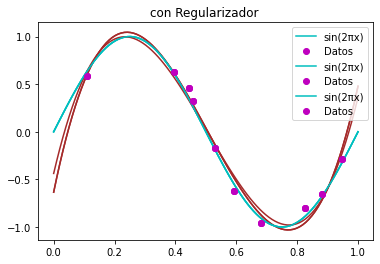

In [8]:
#SENOIDAL VS PREDICCION 
indiceOutlier = errores_sets.index(max(errores_sets)) #elmasgrande
numero_set = 2
w = entrenamiento[1][numero_set]
p = pred(w,eje_x,orden)
plt.title('Sin Regularizador ')
plt.plot(eje_x,p,color = "brown")

plotear(D[numero_set])

wR = entrenamientoR[1][numero_set]
plt.title("con Regularizador ")
pR= pred(wR,eje_x,orden)
plt.plot(eje_x,pR,color = "brown")
plotear(D[numero_set])



w3 = entrenamiento3[1][numero_set]
plt.title("con Regularizador ")
p3= pred(w3,eje_x,orden)
plt.plot(eje_x,p3,color = "brown")
plotear(D[numero_set])



#plt.savefig('ploteoOrden3.png')


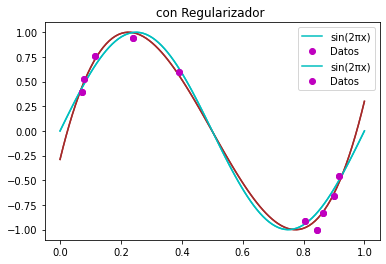

In [9]:
#SENOIDAL VS PREDICCION 
numero_set = 3 #@param {type:"slider", min:0, max:200, step:1}

w = entrenamiento[1][numero_set]
p = pred(w,eje_x,orden)
plt.title('Sin Regularizador ')
plt.plot(eje_x,p,color = "brown")
plotear(D[numero_set])

wR = entrenamientoR[1][numero_set]
plt.title("con Regularizador ")
pR= pred(wR,eje_x,orden)
plt.plot(eje_x,pR,color = "brown")
plotear(D[numero_set])
#plt.savefig('ploteoOrden9.png')

# **3. VALIDATION Y TESTING** 
###Determinaremos la mejor combinación de valores para los hiperparámetros λ
###y M mediante validación cruzada (cross-validation) utilizando los datos del primer punto. Para ello separaremos previamente 20 sets de los 200 datos para testing.

In [10]:
#PROMEDIANDO WS
def promediarW (w):
  res = w[0]
  for i in range(1,len(w)):
    res = res + w[i]
  return res/len(w)

def testPR(orden,reg,setTest,w):
  E = []
  for s in setTest:
    yfit = pred(w,s[0],orden)
    e = errorRegularizador(yfit,s[1],w,0)
    E.append(e)
  return E


In [11]:
#CROSS VALIDATION
def formarParejas(regus,ordenes):
    parejas = []
    for orden in ordenes:
        for reg in regus:
            parejas.append((orden,reg))
    return parejas

def errorMedio(E):
    ret = sum(E)
    return ret/len(E)

def wpart(W,s,part):
    tampart= len(W)//s
    i = (part ) *tampart
    j = (part+1)*tampart
    w1 = W[0:i]
    w2 = W[j:len(W)]
    w = w1 + w2
    return w


def cross(W,D,orden,lam,s):
    e= []
    tampart= len(W)//s
    i = 0
    j = tampart
    h = 0
    for h in range(0,s):
        particion = D[i:j]
        w = wpart(W,s,h)
        wpromedio = promediarW(w)
        errorPart = errorMedio(testPR(orden,lam,particion,wpromedio))
        e.append(errorPart)
        i = i + tampart
        j = j +tampart
       
    return e
       

#AUXILIAR
def promediosParticion(p):
    ret = []
    for i in range (0,len(p)):
        e = sum(p[i])/len(p[0])
        ret.append(e)
    return ret

def crossSobreCadaPareja(D,parejas,s):
    erroresParejas = []
    for pareja in parejas:
        w = train(D,pareja[0],pareja[1],180)[1]
        c = cross(w,D,pareja[0],pareja[1],s)
        p = errorMedio(c)
        erroresParejas.append(p)
    return erroresParejas

In [12]:
#HACEMOS CROSS SOBRE TODAS LAS PAREJAS 

parejas = formarParejas([10*-5,10**-6,10**-7,10**-8,10**-9],[3,4,5,6,7,8,9])

CROSS = crossSobreCadaPareja(D,parejas,5)

indiceMP = CROSS.index(min(CROSS))
import pandas as pd
print("Mejor Pareja :" ,parejas[indiceMP] )
print("Error =", CROSS[indiceMP])
pd.DataFrame({"PAREJAS":parejas,"ERROR CROSS":CROSS})

Mejor Pareja : (3, 1e-06)
Error = 0.06536819161112573


,PAREJAS,ERROR CROSS
0,"(3, -50)",2.724060
1,"(3, 1e-06)",0.065368
2,"(3, 1e-07)",0.065646
3,"(3, 1e-08)",0.065681
4,"(3, 1e-09)",0.065684
5,"(4, -50)",2.773267
6,"(4, 1e-06)",0.132913
7,"(4, 1e-07)",0.186337
8,"(4, 1e-08)",0.226088
9,"(4, 1e-09)",0.235621


ERROR TEST DE LA MEJOR PAREJA
0.060791865104162235


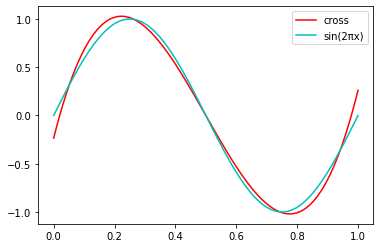

In [13]:
#TESTEO SOBRE LA MEJOR PAREJA
mejorpareja = parejas[indiceMP]
wtest = train(D,mejorpareja[0],mejorpareja[1],180)[1]
wpromediotest = promediarW(wtest)
ERRORTEST = testPR(mejorpareja[0],mejorpareja[1],D[180:200],wpromediotest)
print("ERROR TEST DE LA MEJOR PAREJA")
print(errorMedio(ERRORTEST))
w = train(D,mejorpareja[0],mejorpareja[1],180)[1]
w = promediarW(w)

p = pred(w,eje_x,mejorpareja[0])

plt.plot(eje_x,p,color = "red",label = "cross")
plt.legend(loc="upper right")

eje_x = np.linspace(0, 1, 100)
senoidal = np.sin(2*math.pi*eje_x)

plt.plot(eje_x, senoidal,'c-',label = "sin(2πx)")
plt.legend(loc="upper right")

#  ERRORES DE TESTING SOBRE DIFERENTES PAREJAS



In [14]:
def eTest(regularizadores,ordenes) :
    ret = []
    o = []
    r = []
    for reg in regularizadores:
        for orden in ordenes:
            w = promediarW(train(D,orden,reg,180)[1])
            t = testPR(orden,reg,D[180:200],w)
            a = errorMedio(t)
            ret.append(a)
            r.append(reg)
            o.append(orden)
    return [r,o,ret]

import pandas as pd
regularizadores = [10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9]
dataheatTEST = eTest(regularizadores,[3,4,5,6,7,8,9])
dat = pd.DataFrame({"Regularizador":dataheatTEST[0],"Orden":dataheatTEST[1],"ErrorTest": dataheatTEST[2]})
dat = dat.pivot("Regularizador","Orden","ErrorTest")
dat

Orden,3,4,5,6,7,8,9
Regularizador,,,,,,,
1.000000e-09,0.060781,0.214456,0.134249,0.151095,0.086776,0.143166,1.266381
1.000000e-08,0.060781,0.204340,0.114030,0.125602,0.121748,0.092470,0.070994
1.000000e-07,0.060779,0.161837,0.124917,0.113657,0.113201,0.107561,0.094943
1.000000e-06,0.060792,0.107073,0.139471,0.136163,0.123091,0.107769,0.091715
1.000000e-05,0.063403,0.087987,0.133505,0.163817,0.173547,0.165314,0.145453
1.000000e-04,0.151661,0.090230,0.141485,0.208828,0.264533,0.300700,0.315764
1.000000e-03,0.653693,0.324135,0.208969,0.197397,0.232117,0.284868,0.340529


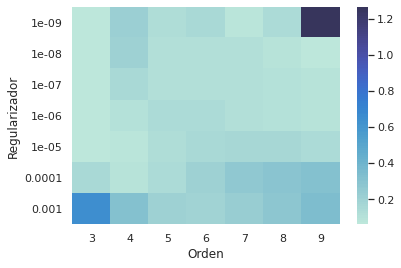

In [21]:
import numpy as np

import seaborn as sns; sns.set()

from google.colab import files
sns.heatmap(dat,center = 1.658 )

#plt.savefig('heatTest.png')
